**Packages**

In [1]:
import numpy as np
import pandas as pd
import math

import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import concatenate
import tensorflow_addons as tfa
import tifffile

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import os

import scipy

2023-03-22 20:57:53.771976: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-22 20:57:55.582682: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-22 20:57:55.582706: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-22 20:57:59.491906: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

**Helper Functions**

In [2]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
   # plt.plot(history.history['accuracy'], label='accuracy')
   # plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.ylim([0, 
            max(
                max(history.history['loss']),
                max(history.history['val_loss'])
            )])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend()
    plt.grid(True)

In [3]:
def plot_accuracy(history):
   # plt.plot(history.history['loss'], label='loss')
   # plt.plot(history.history['val_loss'], label='val_loss')
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.ylim([0, 
            max(
                max(history.history['accuracy']),
                max(history.history['val_accuracy'])
            )])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.grid(True)

In [4]:
def plot_f1(history):
    plt.plot(history.history['f1'], label='train_f1')
    plt.plot(history.history['val_f1'], label='val_f1')
    plt.ylim([0, 
            max(
                max(history.history['f1']),
                max(history.history['val_f1'])
            )])
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title('F1 Score')
    plt.legend()
    plt.grid(True)

In [5]:
# FROM https://github.com/jimmyyhwu/resnet18-tf2/blob/master/resnet.py

kaiming_normal = keras.initializers.VarianceScaling(scale=2.0, mode='fan_out', distribution='untruncated_normal')

def conv3x3(x, out_planes, stride=1, name=None):
    x = layers.ZeroPadding2D(padding=1, name=f'{name}_pad')(x)
    return layers.Conv2D(filters=out_planes, kernel_size=3, strides=stride, use_bias=False, kernel_initializer=kaiming_normal, name=name)(x)

def basic_block(x, planes, stride=1, downsample=None, name=None):
    identity = x

    out = conv3x3(x, planes, stride=stride, name=f'{name}.conv1')
    out = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=f'{name}.bn1')(out)
    out = layers.ReLU(name=f'{name}.relu1')(out)

    out = conv3x3(out, planes, name=f'{name}.conv2')
    out = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=f'{name}.bn2')(out)

    if downsample is not None:
        for layer in downsample:
            identity = layer(identity)

    out = layers.Add(name=f'{name}.add')([identity, out])
    out = layers.ReLU(name=f'{name}.relu2')(out)

    return out

def make_layer(x, planes, blocks, stride=1, name=None):
    downsample = None
    inplanes = x.shape[3]
    if stride != 1 or inplanes != planes:
        downsample = [
            layers.Conv2D(filters=planes, kernel_size=1, strides=stride, use_bias=False, kernel_initializer=kaiming_normal, name=f'{name}.0.downsample.0'),
            layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=f'{name}.0.downsample.1'),
        ]

    x = basic_block(x, planes, stride, downsample, name=f'{name}.0')
    for i in range(1, blocks):
        x = basic_block(x, planes, name=f'{name}.{i}')

    return x

def resnet(x, blocks_per_layer, num_classes=1000):
    x = layers.ZeroPadding2D(padding=3, name='conv1_pad')(x)
    x = layers.Conv2D(filters=64, kernel_size=7, strides=2, use_bias=False, kernel_initializer=kaiming_normal, name='conv1')(x)
    x = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name='bn1')(x)
    x = layers.ReLU(name='relu1')(x)
    x = layers.ZeroPadding2D(padding=1, name='maxpool_pad')(x)
    x = layers.MaxPool2D(pool_size=3, strides=2, name='maxpool')(x)

    x = make_layer(x, 64, blocks_per_layer[0], name='layer1')
    x = make_layer(x, 128, blocks_per_layer[1], stride=2, name='layer2')
    x = make_layer(x, 256, blocks_per_layer[2], stride=2, name='layer3')
    x = make_layer(x, 512, blocks_per_layer[3], stride=2, name='layer4')

    x = layers.GlobalAveragePooling2D(name='avgpool')(x)
    initializer = keras.initializers.RandomUniform(-1.0 / math.sqrt(512), 1.0 / math.sqrt(512))
    x = layers.Dense(units=num_classes, kernel_initializer=initializer, bias_initializer=initializer, name='fc')(x)

    return x

def resnet18(x, **kwargs):
    return resnet(x, [2, 2, 2, 2], **kwargs)

def resnet34(x, **kwargs):
    return resnet(x, [3, 4, 6, 3], **kwargs)

**Data Pre-Processing**

Pulling in Train and Test Sets

In [6]:
tiles_train = pd.read_csv(r'./Data/Tiles_TRAIN.csv')
x_train = tiles_train.drop(['Tile_ID', 'bins_numeric'], axis = 1)
y_train = tiles_train['bins_numeric']
x_train.head(5)

,Stop_Signs,Paving_historical,Bus_stop,Collisions_Historical,RTTYP_I,RTTYP_M,RTTYP_O,RTTYP_S,RTTYP_U,94101,...,94129,94130,94131,94132,94133,94134,94141,94143,94158,94188
0,0.0,0.0,0.0,2.0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0.0,0.0,0.0,0.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.0,0.0,0.0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1.0,0.0,1.0,0.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2.0,0.0,0.0,0.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
tiles_test = pd.read_csv(r'./Data/Tiles_TEST.csv')
x_test = tiles_test.drop(['Tile_ID','bins_numeric'], axis = 1)
y_test = tiles_test['bins_numeric']
x_test.head(5)

,Stop_Signs,Paving_historical,Bus_stop,Collisions_Historical,RTTYP_I,RTTYP_M,RTTYP_O,RTTYP_S,RTTYP_U,94101,...,94129,94130,94131,94132,94133,94134,94141,94143,94158,94188
0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,1.0,0.0,3.0,6.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.0,0.0,0.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0.0,0.0,0.0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0.0,0.0,0.0,0.0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


Image Pre-Processing

In [8]:
# TRAIN SET 

IMAGE_PATH = './Satellite Imagery/Satellite Images Tiled/' 

def preprocess_data_part1(IMAGE_PATH):
    """ Generate lists of images and labelsbased on temp_no_refer and temp_refer lists
    
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    
    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, 149 3)
    """
    
    data_mini = []
    
    for id in tiles_train['Tile_ID']:    
                    
        # read image and store as matrix            
        # Index at the end makes all images the same size (they sometimes differ by 1 pixel)
        image = tifffile.imread(IMAGE_PATH + str(id) + '.tif')[0:148, 0:188, :]
            
        # append to images
        data_mini.append(image)
 
    # stack images and trasnform to array
    images_mini = np.stack(data_mini)
    
    return images_mini

In [9]:
images_mini = preprocess_data_part1(IMAGE_PATH)
np.shape(images_mini)

(8376, 148, 188, 4)

In [10]:
# TEST SET

IMAGE_PATH = './Satellite Imagery/Satellite Images Tiled/' 

def preprocess_data_part2(IMAGE_PATH):
    """ Generate lists of images and labelsbased on temp_no_refer and temp_refer lists
    
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    
    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, 149 3)
    """
    
    data_mini = []
    
    for id in tiles_test['Tile_ID']:    
                    
        # read image and store as matrix            
        # Index at the end makes all images the same size (they sometimes differ by 1 pixel)
        image = tifffile.imread(IMAGE_PATH + str(id) + '.tif')[0:148, 0:188, :]
            
        # append to images
        data_mini.append(image)
 
    # stack images and trasnform to array
    images_mini = np.stack(data_mini)
    
    return images_mini

In [11]:
images_mini_t = preprocess_data_part2(IMAGE_PATH)
np.shape(images_mini_t)

(2095, 148, 188, 4)

Street Data Pre-Processing

In [12]:
# TRAIN SET 

street = np.asarray(x_train).astype('float32')
street_mini = []
for row in range(len(street)):
    street_mini.append([[street[row]]])
street_mini = np.stack(street_mini)
np.shape(street_mini)

(8376, 1, 1, 39)

In [13]:
# TEST SET 

street_t = np.asarray(x_test).astype('float32')
street_mini_t = []
for row in range(len(street_t)):
    street_mini_t.append([[street_t[row]]])
street_mini_t = np.stack(street_mini_t)
np.shape(street_mini_t)

(2095, 1, 1, 39)

**Modeling**

Helpful Links: <br>
https://pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/ <br>
https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50 <br>
https://github.com/jimmyyhwu/resnet18-tf2/blob/master/resnet.py <BR>

**Model 2.3.0: Baseline (Best From Stage 2, LR = 0.0001, decreased kernel and stride size)**

In [14]:
# From previous experiments, adding layers and using ResNet-18 yielded best results 

# x: Satellite Images, 'Stop_Signs', 'Paving_historical', 'Bus_stop', 'Collisions_Historical', Road type (one hot), Zipcode (ont hot)
# y: Future collision bin

# ACCORDING TO THE PAPER, THEY DOWNSIZED THE IMAGES FIRST INTO SMALLER MATRICES 
# THEN ADDED THE STREET CHARACTERISTICS TO THE SMALLER MATRIX
# REFERENCE THE DIAGRAM ON THE PAPER

def create_cnn_model():

    # INPUT LAYERS
    input1 = tf.keras.layers.Input(shape=(148, 188, 4), name='Input_Images')
    input2 = tf.keras.layers.Input(shape=(1,1,39), name='Input_Street') 
    
    #CNN FOR IMAGE PROCESSING
    cnn = tf.keras.layers.Conv2D(39, (2,2), activation="relu")(input1) # layers = street data dimension
    pooling = tf.keras.layers.MaxPooling2D((2, 2), strides=1)(cnn)
    images = tf.keras.models.Model(inputs=input1, outputs=pooling)
    
    #ADDING STREET DATA
    #combined = tf.keras.layers.Concatenate(axis = 2)([images.output, input2])
    combined = tf.keras.layers.Add()([images.output, input2])
    
    # PAPER USES RESNET-18 FOR THE REST OF THE MODEL WITH THE COMBINED DATA
    resnet = resnet18(combined)
    output = tf.keras.layers.Dense(units=11, activation='softmax', name='output')(resnet) # units = number of classes
    
    #instantiation layer 
    cnn_model = tf.keras.models.Model(inputs=[input1, input2], outputs=output)
    
    return cnn_model

cnn_model = create_cnn_model()

cnn_model.summary()

f1 = tfa.metrics.F1Score(
    num_classes = 11,
    average = 'macro',
    threshold = None,
    name = 'f1',
    )

cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics = ['accuracy', f1])

class_weight = {0: 1,
                1: 10,
                2: 10,
                3: 10,
                4: 10,
                5: 10,
                6: 10,
                7: 10,
                8: 10,
                9: 10,
                10: 10,
                # 11: 10,
               }

y = tf.keras.utils.to_categorical(y_train, num_classes=11)

history = cnn_model.fit(
    [images_mini, street_mini],
    y,
    epochs=10,
    # Suppress logging.
     verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2,
    class_weight = class_weight
    )

2023-03-22 09:15:20.335456: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-22 09:15:20.335491: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-22 09:15:20.335518: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-82-179): /proc/driver/nvidia/version does not exist
2023-03-22 09:15:20.341215: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/ubuntu/capstone/lib/python3.10/site-packages/keras/initialize

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Images (InputLayer)      [(None, 148, 188, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 147, 187, 39  663         ['Input_Images[0][0]']           
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 146, 186, 39  0           ['conv2d[0][0]']                 
                                )                                                           

/home/ubuntu/capstone/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


 g2D)                                                                                             
                                                                                                  
 layer2.1.conv1 (Conv2D)        (None, 19, 24, 128)  147456      ['layer2.1.conv1_pad[0][0]']     
                                                                                                  
 layer2.1.bn1 (BatchNormalizati  (None, 19, 24, 128)  512        ['layer2.1.conv1[0][0]']         
 on)                                                                                              
                                                                                                  
 layer2.1.relu1 (ReLU)          (None, 19, 24, 128)  0           ['layer2.1.bn1[0][0]']           
                                                                                                  
 layer2.1.conv2_pad (ZeroPaddin  (None, 21, 26, 128)  0          ['layer2.1.relu1[0][0]']         
 g2D)     

2023-03-22 09:15:21.530208: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 2982732800 exceeds 10% of free system memory.


Epoch 1/10
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
210/210 [==============================] - ETA: 0s - loss: 3.6863 - accuracy: 0.4970 - f1: 0.1102

2023-03-22 09:30:34.833343: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 746128384 exceeds 10% of free system memory.


210/210 [==============================] - 1010s 5s/step - loss: 3.6863 - accuracy: 0.4970 - f1: 0.1102 - val_loss: 1.6435 - val_accuracy: 0.3288 - val_f1: 0.0720
Epoch 2/10
210/210 [==============================] - 1683s 8s/step - loss: 2.9954 - accuracy: 0.5927 - f1: 0.1641 - val_loss: 0.9333 - val_accuracy: 0.5859 - val_f1: 0.1333
Epoch 3/10
210/210 [==============================] - 1646s 8s/step - loss: 2.3177 - accuracy: 0.6879 - f1: 0.2186 - val_loss: 1.0118 - val_accuracy: 0.5412 - val_f1: 0.1200
Epoch 4/10
210/210 [==============================] - 1658s 8s/step - loss: 1.5274 - accuracy: 0.7790 - f1: 0.3449 - val_loss: 0.9822 - val_accuracy: 0.6510 - val_f1: 0.1329
Epoch 5/10
210/210 [==============================] - 1660s 8s/step - loss: 0.9230 - accuracy: 0.8496 - f1: 0.4312 - val_loss: 1.3014 - val_accuracy: 0.6199 - val_f1: 0.1321
Epoch 6/10
210/210 [==============================] - 1643s 8s/step - loss: 0.6221 - accuracy: 0.8893 - f1: 0.5159 - val_loss: 1.4464 - val_a

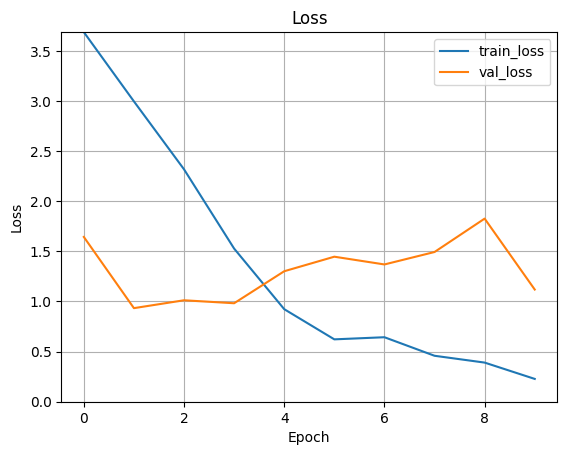

In [15]:
plot_loss(history)

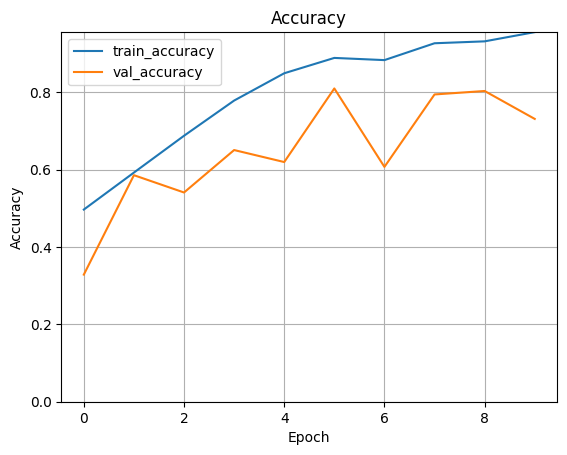

In [16]:
plot_accuracy(history)

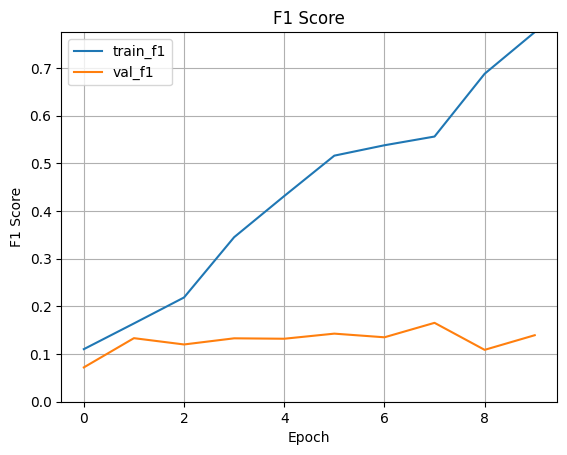

In [17]:
plot_f1(history)

**Model 2.3.1: Added More Layers to Initial Image Processing Layer**

In [18]:
# From previous experiments, adding layers and using ResNet-18 yielded best results 

# x: Satellite Images, 'Stop_Signs', 'Paving_historical', 'Bus_stop', 'Collisions_Historical', Road type (one hot), Zipcode (ont hot)
# y: Future collision bin

# ACCORDING TO THE PAPER, THEY DOWNSIZED THE IMAGES FIRST INTO SMALLER MATRICES 
# THEN ADDED THE STREET CHARACTERISTICS TO THE SMALLER MATRIX
# REFERENCE THE DIAGRAM ON THE PAPER

def create_cnn_model():

    # INPUT LAYERS
    input1 = tf.keras.layers.Input(shape=(148, 188, 4), name='Input_Images')
    input2 = tf.keras.layers.Input(shape=(1,1,39), name='Input_Street') 
    
    #CNN FOR IMAGE PROCESSING
    cnn = tf.keras.layers.Conv2D(50, (2,2), activation="relu")(input1) # additional layer
    pooling = tf.keras.layers.MaxPooling2D((2, 2), strides=1)(cnn) # additional layer
    cnn = tf.keras.layers.Conv2D(39, (2,2), activation="relu")(pooling) # layers = street data dimension
    pooling = tf.keras.layers.MaxPooling2D((2, 2), strides=1)(cnn)
    images = tf.keras.models.Model(inputs=input1, outputs=pooling)
    
    #ADDING STREET DATA
    #combined = tf.keras.layers.Concatenate(axis = 2)([images.output, input2])
    combined = tf.keras.layers.Add()([images.output, input2])
    
    # PAPER USES RESNET-18 FOR THE REST OF THE MODEL WITH THE COMBINED DATA
    resnet = resnet18(combined)
    output = tf.keras.layers.Dense(units=11, activation='softmax', name='output')(resnet) # units = number of classes
    
    #instantiation layer 
    cnn_model = tf.keras.models.Model(inputs=[input1, input2], outputs=output)
    
    return cnn_model

cnn_model = create_cnn_model()

cnn_model.summary()

f1 = tfa.metrics.F1Score(
    num_classes = 11,
    average = 'macro',
    threshold = None,
    name = 'f1',
    )

cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics = ['accuracy', f1])

class_weight = {0: 1,
                1: 10,
                2: 10,
                3: 10,
                4: 10,
                5: 10,
                6: 10,
                7: 10,
                8: 10,
                9: 10,
                10: 10,
                # 11: 10,
               }

y = tf.keras.utils.to_categorical(y_train, num_classes=11)

history = cnn_model.fit(
    [images_mini, street_mini],
    y,
    epochs=10,
    # Suppress logging.
     verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2,
    class_weight = class_weight
    )

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Images (InputLayer)      [(None, 148, 188, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 147, 187, 50  850         ['Input_Images[0][0]']           
                                )                                                                 
                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, 146, 186, 50  0          ['conv2d_1[0][0]']               
                                )                                                           

2023-03-22 13:40:33.597977: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 2982732800 exceeds 10% of free system memory.


210/210 [==============================] - ETA: 0s - loss: 3.6357 - accuracy: 0.4855 - f1: 0.1219

2023-03-22 14:13:41.954055: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 746128384 exceeds 10% of free system memory.


210/210 [==============================] - 2079s 10s/step - loss: 3.6357 - accuracy: 0.4855 - f1: 0.1219 - val_loss: 0.6844 - val_accuracy: 0.7542 - val_f1: 0.1081
Epoch 2/10
210/210 [==============================] - 2037s 10s/step - loss: 2.9698 - accuracy: 0.5791 - f1: 0.1536 - val_loss: 0.9862 - val_accuracy: 0.4851 - val_f1: 0.1104
Epoch 3/10
210/210 [==============================] - 2003s 10s/step - loss: 2.5328 - accuracy: 0.6299 - f1: 0.2062 - val_loss: 1.4056 - val_accuracy: 0.4302 - val_f1: 0.0966
Epoch 4/10
210/210 [==============================] - 1996s 9s/step - loss: 1.6481 - accuracy: 0.7481 - f1: 0.3017 - val_loss: 2.8565 - val_accuracy: 0.2166 - val_f1: 0.0616
Epoch 5/10
210/210 [==============================] - 2068s 10s/step - loss: 1.0702 - accuracy: 0.8263 - f1: 0.4025 - val_loss: 3.0180 - val_accuracy: 0.2387 - val_f1: 0.0550
Epoch 6/10
210/210 [==============================] - 2054s 10s/step - loss: 0.7026 - accuracy: 0.8760 - f1: 0.5352 - val_loss: 1.5753 - 

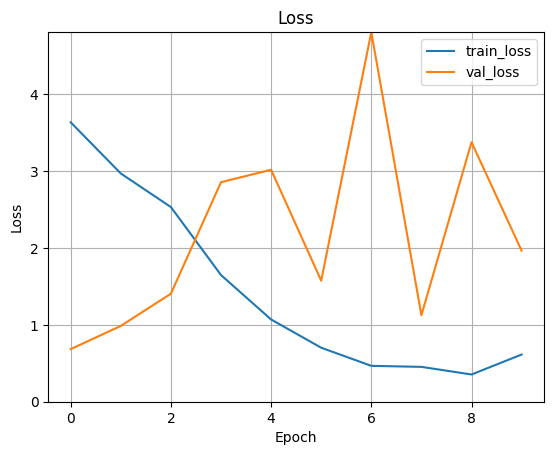

In [19]:
plot_loss(history)

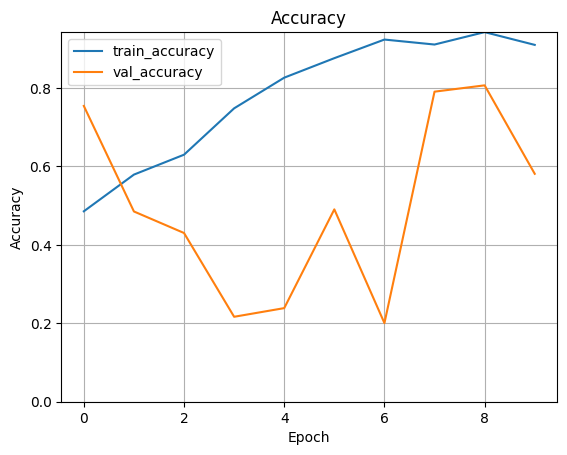

In [20]:
plot_accuracy(history)

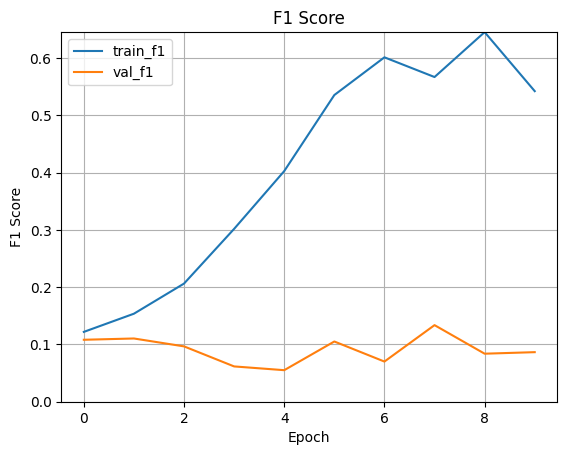

In [21]:
plot_f1(history)

**Model 2.3.2: Added 1 Dropout Layer**

In [14]:
# From previous experiments, adding layers and using ResNet-18 yielded best results 

# x: Satellite Images, 'Stop_Signs', 'Paving_historical', 'Bus_stop', 'Collisions_Historical', Road type (one hot), Zipcode (ont hot)
# y: Future collision bin

# ACCORDING TO THE PAPER, THEY DOWNSIZED THE IMAGES FIRST INTO SMALLER MATRICES 
# THEN ADDED THE STREET CHARACTERISTICS TO THE SMALLER MATRIX
# REFERENCE THE DIAGRAM ON THE PAPER

def create_cnn_model():

    # INPUT LAYERS
    input1 = tf.keras.layers.Input(shape=(148, 188, 4), name='Input_Images')
    input2 = tf.keras.layers.Input(shape=(1,1,39), name='Input_Street') 
    
    #CNN FOR IMAGE PROCESSING
    cnn = tf.keras.layers.Conv2D(39, (2,2), activation="relu")(input1) # layers = street data dimension
    pooling = tf.keras.layers.MaxPooling2D((2, 2), strides=1)(cnn)
    
    dropout = tf.keras.layers.Dropout(0.2)(pooling) # dropout layer 
    
    images = tf.keras.models.Model(inputs=input1, outputs=dropout)
    
    #ADDING STREET DATA
    #combined = tf.keras.layers.Concatenate(axis = 2)([images.output, input2])
    combined = tf.keras.layers.Add()([images.output, input2])
    
    # PAPER USES RESNET-18 FOR THE REST OF THE MODEL WITH THE COMBINED DATA
    resnet = resnet18(combined)
    output = tf.keras.layers.Dense(units=11, activation='softmax', name='output')(resnet) # units = number of classes
    
    #instantiation layer 
    cnn_model = tf.keras.models.Model(inputs=[input1, input2], outputs=output)
    
    return cnn_model

cnn_model = create_cnn_model()

cnn_model.summary()

f1 = tfa.metrics.F1Score(
    num_classes = 11,
    average = 'macro',
    threshold = None,
    name = 'f1',
    )

cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics = ['accuracy', f1])

class_weight = {0: 1,
                1: 10,
                2: 10,
                3: 10,
                4: 10,
                5: 10,
                6: 10,
                7: 10,
                8: 10,
                9: 10,
                10: 10,
                # 11: 10,
               }

y = tf.keras.utils.to_categorical(y_train, num_classes=11)

history = cnn_model.fit(
    [images_mini, street_mini],
    y,
    epochs=10,
    # Suppress logging.
     verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2,
    class_weight = class_weight
    )

2023-03-22 21:00:04.579719: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-22 21:00:04.579756: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-22 21:00:04.579786: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-82-179): /proc/driver/nvidia/version does not exist
2023-03-22 21:00:04.581123: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/ubuntu/capstone/lib/python3.10/site-packages/keras/initialize

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Images (InputLayer)      [(None, 148, 188, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 147, 187, 39  663         ['Input_Images[0][0]']           
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 146, 186, 39  0           ['conv2d[0][0]']                 
                                )                                                           

/home/ubuntu/capstone/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


                                                                  'layer2.0.bn2[0][0]']           
                                                                                                  
 layer2.0.relu2 (ReLU)          (None, 19, 24, 128)  0           ['layer2.0.add[0][0]']           
                                                                                                  
 layer2.1.conv1_pad (ZeroPaddin  (None, 21, 26, 128)  0          ['layer2.0.relu2[0][0]']         
 g2D)                                                                                             
                                                                                                  
 layer2.1.conv1 (Conv2D)        (None, 19, 24, 128)  147456      ['layer2.1.conv1_pad[0][0]']     
                                                                                                  
 layer2.1.bn1 (BatchNormalizati  (None, 19, 24, 128)  512        ['layer2.1.conv1[0][0]']         
 on)      

2023-03-22 21:00:05.720838: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 2982732800 exceeds 10% of free system memory.


Epoch 1/10
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
210/210 [==============================] - ETA: 0s - loss: 3.6608 - accuracy: 0.4679 - f1: 0.0968

2023-03-22 21:07:54.584820: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 746128384 exceeds 10% of free system memory.


210/210 [==============================] - 487s 2s/step - loss: 3.6608 - accuracy: 0.4679 - f1: 0.0968 - val_loss: 2.0281 - val_accuracy: 0.1891 - val_f1: 0.0345
Epoch 2/10
210/210 [==============================] - 476s 2s/step - loss: 3.2350 - accuracy: 0.5330 - f1: 0.1425 - val_loss: 0.8820 - val_accuracy: 0.5322 - val_f1: 0.0912
Epoch 3/10
210/210 [==============================] - 477s 2s/step - loss: 3.0825 - accuracy: 0.5670 - f1: 0.1366 - val_loss: 1.0799 - val_accuracy: 0.1718 - val_f1: 0.0437
Epoch 4/10
210/210 [==============================] - 1529s 7s/step - loss: 2.9795 - accuracy: 0.5879 - f1: 0.1401 - val_loss: 0.6962 - val_accuracy: 0.7792 - val_f1: 0.1169
Epoch 5/10
210/210 [==============================] - 1699s 8s/step - loss: 2.8672 - accuracy: 0.5961 - f1: 0.1540 - val_loss: 1.6557 - val_accuracy: 0.2041 - val_f1: 0.0468
Epoch 6/10
210/210 [==============================] - 1709s 8s/step - loss: 2.6910 - accuracy: 0.6075 - f1: 0.1629 - val_loss: 0.9498 - val_accu

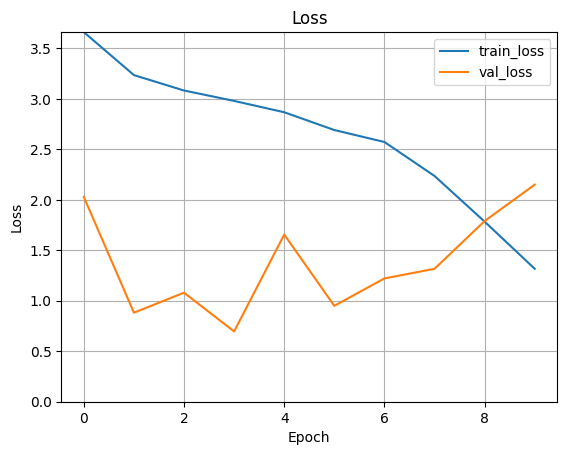

In [15]:
plot_loss(history)

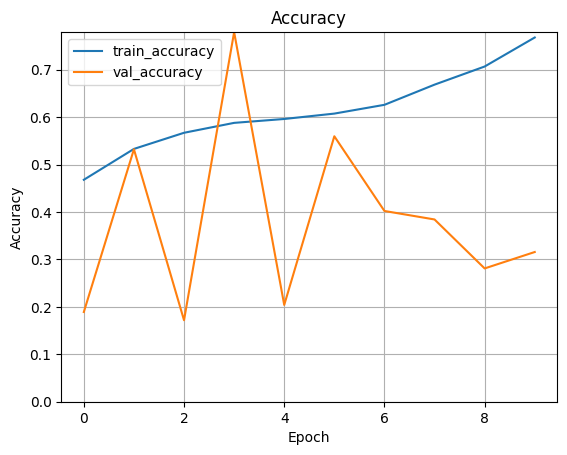

In [16]:
plot_accuracy(history)

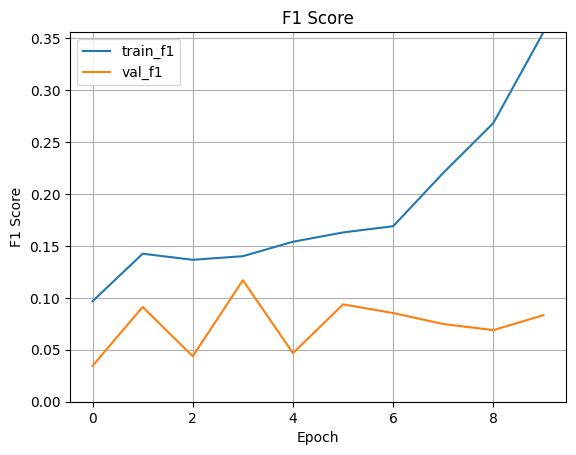

In [17]:
plot_f1(history)

**Model 2.3.3: Added 2 Dropout Layers**

In [18]:
# From previous experiments, adding layers and using ResNet-18 yielded best results 

# x: Satellite Images, 'Stop_Signs', 'Paving_historical', 'Bus_stop', 'Collisions_Historical', Road type (one hot), Zipcode (ont hot)
# y: Future collision bin

# ACCORDING TO THE PAPER, THEY DOWNSIZED THE IMAGES FIRST INTO SMALLER MATRICES 
# THEN ADDED THE STREET CHARACTERISTICS TO THE SMALLER MATRIX
# REFERENCE THE DIAGRAM ON THE PAPER

def create_cnn_model():

    # INPUT LAYERS
    input1 = tf.keras.layers.Input(shape=(148, 188, 4), name='Input_Images')
    input2 = tf.keras.layers.Input(shape=(1,1,39), name='Input_Street') 
    
    #CNN FOR IMAGE PROCESSING
    cnn = tf.keras.layers.Conv2D(39, (2,2), activation="relu")(input1) # layers = street data dimension
    pooling = tf.keras.layers.MaxPooling2D((2, 2), strides=1)(cnn)
    
    dropout = tf.keras.layers.Dropout(0.2)(pooling) # dropout layer 1
    
    images = tf.keras.models.Model(inputs=input1, outputs=dropout)
    
    #ADDING STREET DATA
    #combined = tf.keras.layers.Concatenate(axis = 2)([images.output, input2])
    combined = tf.keras.layers.Add()([images.output, input2])
    
    # PAPER USES RESNET-18 FOR THE REST OF THE MODEL WITH THE COMBINED DATA
    resnet = resnet18(combined)
    
    dropout = tf.keras.layers.Dropout(0.2)(resnet) # dropout layer 2
    
    output = tf.keras.layers.Dense(units=11, activation='softmax', name='output')(dropout) # units = number of classes
    
    #instantiation layer 
    cnn_model = tf.keras.models.Model(inputs=[input1, input2], outputs=output)
    
    return cnn_model

cnn_model = create_cnn_model()

cnn_model.summary()

f1 = tfa.metrics.F1Score(
    num_classes = 11,
    average = 'macro',
    threshold = None,
    name = 'f1',
    )

cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics = ['accuracy', f1])

class_weight = {0: 1,
                1: 10,
                2: 10,
                3: 10,
                4: 10,
                5: 10,
                6: 10,
                7: 10,
                8: 10,
                9: 10,
                10: 10,
                # 11: 10,
               }

y = tf.keras.utils.to_categorical(y_train, num_classes=11)

history = cnn_model.fit(
    [images_mini, street_mini],
    y,
    epochs=10,
    # Suppress logging.
     verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2,
    class_weight = class_weight
    )

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Images (InputLayer)      [(None, 148, 188, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 147, 187, 39  663         ['Input_Images[0][0]']           
                                )                                                                 
                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, 146, 186, 39  0          ['conv2d_1[0][0]']               
                                )                                                           

2023-03-23 00:42:45.053142: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 2982732800 exceeds 10% of free system memory.


210/210 [==============================] - ETA: 0s - loss: 3.8492 - accuracy: 0.4534 - f1: 0.1077

2023-03-23 01:10:24.024353: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 746128384 exceeds 10% of free system memory.


210/210 [==============================] - 1711s 8s/step - loss: 3.8492 - accuracy: 0.4534 - f1: 0.1077 - val_loss: 0.8382 - val_accuracy: 0.7947 - val_f1: 0.0994
Epoch 2/10
210/210 [==============================] - 1746s 8s/step - loss: 3.3438 - accuracy: 0.5199 - f1: 0.1245 - val_loss: 1.1650 - val_accuracy: 0.3663 - val_f1: 0.0669
Epoch 3/10
210/210 [==============================] - 1785s 9s/step - loss: 3.1030 - accuracy: 0.5590 - f1: 0.1284 - val_loss: 1.1806 - val_accuracy: 0.3502 - val_f1: 0.0979
Epoch 4/10
210/210 [==============================] - 1724s 8s/step - loss: 3.1584 - accuracy: 0.5469 - f1: 0.1322 - val_loss: 0.5565 - val_accuracy: 0.8115 - val_f1: 0.0938
Epoch 5/10
210/210 [==============================] - 1693s 8s/step - loss: 2.9116 - accuracy: 0.5961 - f1: 0.1481 - val_loss: 0.8852 - val_accuracy: 0.6122 - val_f1: 0.1203
Epoch 6/10
210/210 [==============================] - 1712s 8s/step - loss: 2.8336 - accuracy: 0.5876 - f1: 0.1494 - val_loss: 0.7061 - val_a

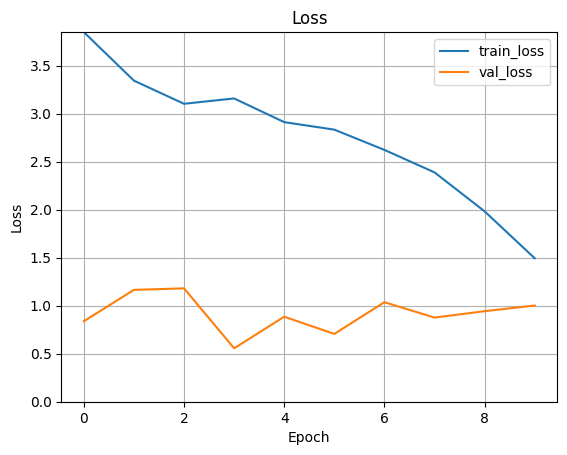

In [19]:
plot_loss(history)

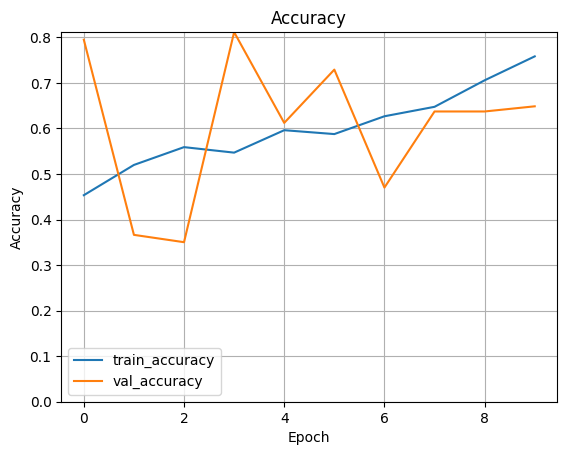

In [20]:
plot_accuracy(history)

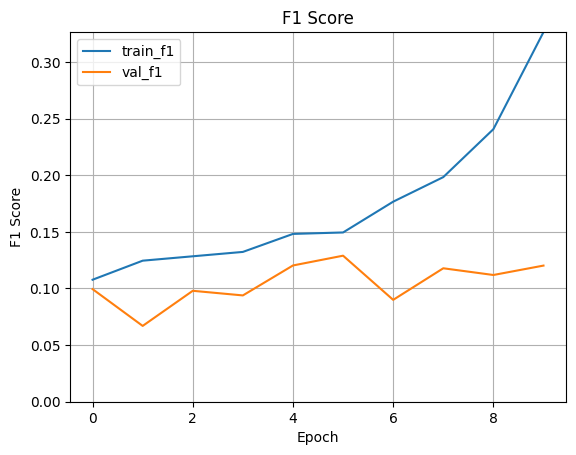

In [21]:
plot_f1(history)